In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

# Problem 1
## Dataset Generation

Write a function to **generate a training set** of size $m$
- randomly generate a weight vector $w \in \mathbb{R}^{10}$, normalize length
- generate a training set $\{(x_i , y_i)\}$ of size m
  - $x_i$: random vector in $\mathbb{R}^{10}$ from $\textbf{N}(0, I)$
  - $y_i$: $\{0, +1\}$ with $P[y = +1] = \sigma(w \cdot x_i)$ and $P[y = 0] = 1 - \sigma(w \cdot x_i)$

In [21]:
def generate_data(m):
    # returns the true w as well as X, Y data
    w = np.random.normal(loc=0, scale=1, size=10)
    w = w / np.linalg.norm(w)
    
    X, Y = [], []
    for _ in range(m):
        x = np.random.normal(loc=0, scale=1, size=10)
        p = 1 / (1 + np.exp(-np.sum(w * x)))
        y = np.random.choice([0, 1], p=[1-p, p])
        X.append(x)
        Y.append(y)
    return w, (X, Y)

## Algorithm 1: logistic regression

The goal is to learn $w$.  Algorithm 1 is logistic
  regression (you may use the built-in method LogisticRegression for this. Use max_iter=1000).

In [3]:
ms = list(range(50, 300, 50))

In [4]:
tic = time()
errors_log_reg = []
for m in ms:
    errors = []
    for _ in range(10):
        lg = LogisticRegression(max_iter=1000, random_state=101)
        w, (X,Y) = generate_data(m)
        lg.fit(X, Y)
        w_pred = lg.coef_.squeeze()
        error = np.linalg.norm(w - w_pred)
        errors.append(error)
    errors_log_reg.append(np.mean(errors))
        
toc = time()
time_log_reg = toc - tic

## Algorithm 2: gradient descent with square loss

Define square loss as
$$L_i(w^{(t)}) = \frac{1}{2} \left( \sigma(w^{(t)} \cdot x) - y_i \right)^2$$

  Algorithm 2 is
  gradient descent with respect to square loss (code this
  up yourself -- run for 1000 iterations, use step size eta = 0.01).

In [5]:
def sigmoid(w, x):
    return 1 / (1 + np.exp(-np.sum(x*w)))

def grad_step(w, x, y):
    s = sigmoid(w, x)
    return (s - y) * s * (1 - s) * x

In [6]:
n_steps = 1000
eta = 0.01

In [10]:
tic = time()
errors_gd = []
for m in tqdm(ms):
    errors = []
    for _ in range(10):
        w, (X,Y) = generate_data(m)
        w_pred = np.zeros_like(w)
        for step in range(n_steps):
            grad_cum = np.mean(np.array([grad_step(w_pred, x, y) for x,y in zip(X, Y)]), axis=0)
            w_pred = w_pred - eta * grad_cum
        error = np.linalg.norm(w - w_pred)
        errors.append(error)
    errors_gd.append(np.mean(errors))
        
toc = time()
time_taken_gd = toc - tic

100%|██████████| 5/5 [01:19<00:00, 15.88s/it]


## Algorithm 3: stochastic gradient descent with square loss
Similar to gradient descent, except we use the gradient at a single random training point every iteration.

In [12]:
tic = time()
errors_sgd = []
for m in ms:
    errors = []
    for _ in range(10):
        w, (X,Y) = generate_data(m)
        w_pred = np.zeros_like(w)
        for step in range(n_steps):
            ind = np.random.randint(m)
            x, y = X[ind], Y[ind]
            w_pred = w_pred - eta * grad_step(w_pred, x, y)
        error = np.linalg.norm(w - w_pred)
        errors.append(error)
    errors_sgd.append(np.mean(errors))
        
toc = time()
time_taken_sgd = toc - tic

## Evaluation

Measure error $\|w - \hat{w}\|_2$ for each method at different sample size. For any
  fixed value of $m$, choose many different $w$'s and average the
  values $\|w - 
  \hat{w}\|_2$ for Algorithms 1, 2 and 3.  Plot the results
  for for each algorithm as you make $m$ large (use $m=50, 100, 150, 200, 250$).
  Also record, for each algorithm, the time taken to run the overall experiment.

Logistic regression, overall time taken: 0.42 sec
Gradient descent, overall time taken: 79.39 sec
Stochastic gradient descent, overall time taken: 1.43 sec


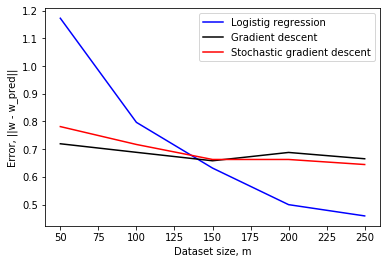

In [13]:
print(f"Logistic regression, overall time taken: {time_log_reg:.2f} sec")
print(f"Gradient descent, overall time taken: {time_taken_gd:.2f} sec")
print(f"Stochastic gradient descent, overall time taken: {time_taken_sgd:.2f} sec")
plt.plot(ms, errors_log_reg, c='b', label="Logistig regression")
plt.plot(ms, errors_gd, c='k', label="Gradient descent")
plt.plot(ms, errors_sgd, c='r', label="Stochastic gradient descent")
plt.legend()
plt.xlabel("Dataset size, m")
plt.ylabel("Error, ||w - w_pred||")
plt.show();

NB: it seems that bigger step size is needed. For example, choosing step_size = 0.1 leads to GD performs as good as logistic regression.

# Problem 2

In [14]:
from sklearn import datasets
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [15]:
cancer = datasets.load_breast_cancer()

For each depth in $1, \dots, 5$, instantiate an AdaBoost classifier with the base learner set to be a decision tree of that depth (set `n_estimators=10` and `learning_rate=1`), and then record the 10-fold cross-validated error on the entire breast cancer data set. Plot the resulting curve of accuracy against base classifier depth. Use $101$ as your random state for both the base learner as well as the AdaBoost classifier every time.

In [16]:
depths = list(range(1, 6))
lr = 1
n_estimators = 10
random_state = 101
scores = []
cv = KFold(n_splits=10, shuffle=True, random_state=random_state)
for depth in depths:
    decision_tree = DecisionTreeClassifier(max_depth=depth, random_state=random_state)
    ada_boost = AdaBoostClassifier(base_estimator=decision_tree,
                                   random_state=random_state,
                                   n_estimators=n_estimators,
                                   learning_rate=lr)
    scores.append(cross_val_score(ada_boost, cancer.data, cancer.target, cv=cv).mean())

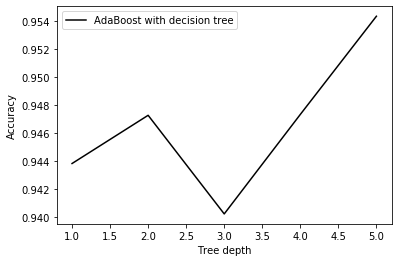

In [17]:
plt.plot(depths, scores, c='k', label="AdaBoost with decision tree")
plt.xlabel("Tree depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show();